In [1]:
#Modules
import os
import gc
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
print("GPUs available:", tf.config.list_physical_devices('GPU'))

from skimage.transform import resize
from sklearn.model_selection import train_test_split
from PIL import Image
from scipy import ndimage
from torch.utils.data import Dataset, DataLoader, TensorDataset
from scipy.ndimage import zoom

import tensorflow
from tensorflow.keras import metrics
from tensorflow import keras
from collections import Counter
from tensorflow.keras.utils import to_categorical
from keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv3D, Input, MaxPooling3D, Dropout, concatenate, UpSampling3D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
DataPathTrain = './PDAC_NPprepedData/TrainingData/'
LabelPathTrain = './PDAC_NPprepedData/TrainingLabels/'

DataPathTest = './PDAC_NPprepedData/TestingData/'
LabelPathTest = './PDAC_NPprepedData/TestingLabels/'

def isValidFile(path):
    return os.path.isfile(path) and not path.endswith('.ipynb_checkpoints')

X_train = [np.load(os.path.join(DataPathTrain, x)) for x in sorted(os.listdir(DataPathTrain)) if isValidFile(os.path.join(DataPathTrain, x))]
y_train = [np.load(os.path.join(LabelPathTrain, x)) for x in sorted(os.listdir(LabelPathTrain)) if isValidFile(os.path.join(LabelPathTrain, x))]

X_temp = [np.load(os.path.join(DataPathTest, x)) for x in sorted(os.listdir(DataPathTest)) if isValidFile(os.path.join(DataPathTest, x))]
y_temp = [np.load(os.path.join(LabelPathTest, x)) for x in sorted(os.listdir(LabelPathTest)) if isValidFile(os.path.join(LabelPathTest, x))]

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=4, random_state=42)

In [3]:
len(X_val)

50

In [4]:
label_img = y_train[0]
unique_values = np.unique(label_img)

print("Unique values in the first label scan:", unique_values)

Unique values in the first label scan: [0 1 2]


In [5]:
#print(np.unique(npLabelDict[LabelArray[2]]))
print(len(np.unique(y_test[2])))

print(y_test[2].shape)
print(X_test[2].shape)

print(np.array(y_train).shape)
#npScanArray[2].dtype

3
(128, 128, 128, 1)
(128, 128, 128, 1)
(212, 128, 128, 128, 1)


In [6]:
def getslice(scanVal, sliceVal, arrayType='scan'):
    sliceData = X_val[scanVal] if arrayType == 'scan' else y_val[scanVal]
    sliceGot = sliceData[ :, :, sliceVal, 0]
    
    return sliceGot

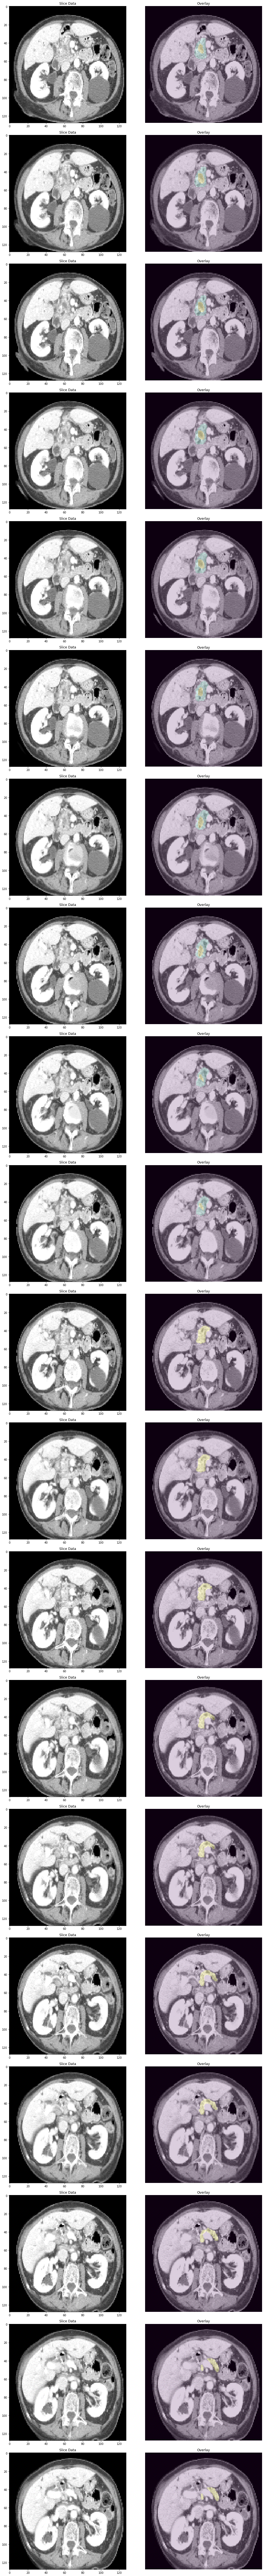

In [7]:
scanVal = 22
sliceVal = 55

sliceData = getslice(scanVal, sliceVal, 'scan')
scanData = getslice(scanVal, sliceVal, 'label')

fig, axes = plt.subplots(20, 2, figsize=(15, 130))

for i in range(20):
    #Original pancreas image.
    axes[i, 0].imshow(getslice(scanVal, sliceVal+i, 'scan'), cmap='gray')
    axes[i, 0].set_title('Slice Data')

    #Supersizing image
    axes[i, 1].imshow(getslice(scanVal, sliceVal+i, 'scan'), cmap='gray')
    axes[i, 1].imshow(getslice(scanVal, sliceVal+i, 'label'), alpha=0.195)
    axes[i, 1].set_title('Overlay')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [8]:
voxel_labels = np.array(y_train).flatten()
unique_labels, class_counts = np.unique(voxel_labels, return_counts=True)
total_voxels = np.sum(class_counts)

In [9]:
print(f'{class_counts[0] / total_voxels: .2%}')

 99.59%


In [10]:
class_weights = {label: total_voxels / (len(unique_labels) * count) for label, count in zip(unique_labels, class_counts)}

In [11]:
class_weights

{0: 0.33470094384555626, 1: 93.76652401211088, 2: 627.5831547684585}

In [12]:
# Flatten spatial dimensions
y_train_flat = np.array(y_train).reshape(-1)

# Create sample weights
sample_weights = np.array([class_weights[val] for val in y_train_flat])

# Reshape sample weights to match original data shape
sample_weights = sample_weights.reshape(np.array(y_train).shape[:-1])

In [13]:
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train, sample_weights))
validation_loader = tf.data.Dataset.from_tensor_slices((X_val, y_val))
testing_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [14]:
batch_size = 2

train_dataset = (
    train_loader.shuffle(len(X_train))
#     .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(X_val))
#     .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

test_dataset = (
    testing_loader.shuffle(len(X_test))
    .batch(batch_size)
    .prefetch(2)
)

In [15]:
# Building the convolutional block
def ConvBlock(inputs, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = layers.Conv3D(filters, kernel_size = (3,3,3), padding = "same")(inputs)
    batch_norm1 = layers.BatchNormalization()(conv1)
    act1 = layers.ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = layers.Conv3D(filters, kernel_size = (3,3,3), padding = "same")(act1)
    batch_norm2 = layers.BatchNormalization()(conv2)
    act2 = layers.ReLU()(batch_norm2)
    
    return act2

# Building the encoder
def encoder(inputs, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = ConvBlock(inputs, filters)
    MaxPool1 = layers.MaxPooling3D(strides = (2,2,2))(enc1)
    return enc1, MaxPool1

# Building the decoder
def decoder(inputs, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = layers.Conv3DTranspose(filters, (2, 2, 2), strides=2, padding="same")(inputs)
    Connect_Skip = layers.Concatenate()([Upsample, skip])
    out = ConvBlock(Connect_Skip, filters)
    return out


In [16]:
def get_U_Net(width=128, height=128, depth=128):
    inputs = Input((width, height, depth, 1))
    
    # Construct the encoder blocks and increasing the filters by a factor of 2
    skip1, encoder_1 = encoder(inputs, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = ConvBlock(encoder_4, 64*16)
    
    # Construct the decoder blocks and decreasing the filters by a factor of 2
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    outputs = layers.Conv3D(3, 1, activation='softmax')(decoder_4)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = get_U_Net(width=128, height=128, depth=128)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 128 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 128 256         conv3d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 128, 128, 128 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', 
            tf.keras.metrics.SparseCategoricalAccuracy(),
            #MeanIOU3D(num_classes=3)
            ])

#Added softmax activation and also removed from logits.

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

csv_logger = tf.keras.callbacks.CSVLogger('metrics.csv')

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_dataset,
    epochs=5, #test
    validation_data=validation_dataset,
    callbacks=[early_stop, checkpoint, csv_logger],
)

Epoch 1/5
106/106 [==============================] - 306s 3s/step - loss: 0.9065 - accuracy: 0.5874 - sparse_categorical_accuracy: 0.5874 - val_loss: 1.1690 - val_accuracy: 0.4242 - val_sparse_categorical_accuracy: 0.4242
Epoch 2/5
106/106 [==============================] - 294s 3s/step - loss: 0.8690 - accuracy: 0.6971 - sparse_categorical_accuracy: 0.6971 - val_loss: 0.6372 - val_accuracy: 0.7661 - val_sparse_categorical_accuracy: 0.7661
Epoch 3/5
106/106 [==============================] - 294s 3s/step - loss: 0.5972 - accuracy: 0.8546 - sparse_categorical_accuracy: 0.8546 - val_loss: 8.0187 - val_accuracy: 0.1065 - val_sparse_categorical_accuracy: 0.1065
Epoch 4/5
106/106 [==============================] - 295s 3s/step - loss: 0.6650 - accuracy: 0.8796 - sparse_categorical_accuracy: 0.8796 - val_loss: 0.2959 - val_accuracy: 0.9457 - val_sparse_categorical_accuracy: 0.9457
Epoch 5/5
106/106 [==============================] - 294s 3s/step - loss: 0.5150 - accuracy: 0.9258 - sparse_cat

In [26]:
prediction_masks = np.array(model.predict(test_dataset))

In [27]:
print("prediction_mask shape:", np.array(prediction_masks).shape)
print(np.array(X_test).shape)

prediction_mask shape: (4, 128, 128, 128, 3)
(4, 128, 128, 128, 1)


In [28]:
predicted_classes = np.argmax(prediction_masks[1], axis=-1)
print("Shape", predicted_classes.shape)
print("Unique", np.unique(predicted_classes))

print("Expected", np.unique(y_test[1]))

Shape (128, 128, 128)
Unique [0 1 2]
Expected [0 1 2]


In [29]:
print("Raw predictions shape:", prediction_masks[1].shape)
print("Unique values in raw predictions:", np.unique(prediction_masks[1]))
print("Unique values in predicted_classes:", np.unique(predicted_classes))


Raw predictions shape: (128, 128, 128, 3)
Unique values in raw predictions: [9.857810e-04 9.866578e-04 9.927081e-04 ... 9.874215e-01 9.875422e-01
 9.885771e-01]
Unique values in predicted_classes: [0 1 2]


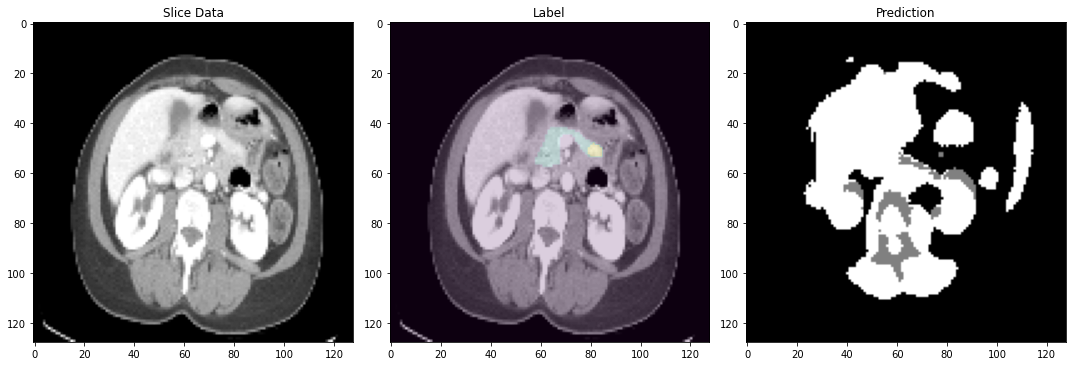

In [30]:
scanVal = 2
sliceVal = 45

sliceData = np.squeeze(X_test[scanVal], axis=-1)
labelData = np.squeeze(y_test[scanVal], axis=-1)
predictionData = np.argmax(prediction_masks[scanVal], axis=-1)

sliceGot = sliceData[:, :, sliceVal]
labelGot = labelData[:, :, sliceVal]
predictionGot = predictionData[:, :, sliceVal]


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(sliceGot, cmap='gray')
axes[0].set_title('Slice Data')

axes[1].imshow(sliceGot, cmap='gray')
axes[1].imshow(labelGot, alpha=0.195)
axes[1].set_title('Label')

#axes[2].imshow(sliceGot, cmap='gray')
axes[2].imshow(predictionGot, cmap='gray')
axes[2].set_title('Prediction')

plt.tight_layout()
plt.show()


In [24]:
#https://github.com/fitushar/3DUnet_tensorflow2.0/blob/master/Unet3D.py
#k3d for 3d view possibly.

In [25]:
#Reason it takes so long to process the dataset is because the gpu is settup to process channel first data.
#Fixed the issue with resizing by changing the values to nearest neighbor for the labels, forgot to change after 
#Changing resize method.
#And then also fixed an issue where the testing labels where literally just the scans itself, idk how I missed that.